## COMP5513 Project - Stock Price Prediction
### **Use LSTM with technical indicator to predict the closing price of 2800.HK.**


In [ ]:
# install packages
!pip install yfinance
!pip install pandas-ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 5.3 MB/s 
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218922 sha256=6d87155c9022102ad67f430f1dca3f5c266f1b0d52c5f27da397c36548618cc0
  Stored in directory: /root/.cache/pip/wheels/0b/81/f0/cca85757840e4616a2c6b9fe12569d97d324c27cac60724c58
Successfully built pandas-ta


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta

# download the data of 2800.HK 
df = yf.download(tickers = '2800.HK', start = '2012-01-01',end = '2022-08-31')
# return first 5 data
df.head()
#print(df.shape)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,19.00,19.040001,18.900000,19.02,19.02,7413484
2012-01-04,19.02,19.080000,18.860001,18.90,18.90,16617291
2012-01-05,19.00,19.020000,18.900000,19.00,19.00,13039191
2012-01-06,18.92,18.940001,18.639999,18.74,18.74,16093831
2012-01-09,18.74,19.100000,18.459999,19.08,19.08,12007378


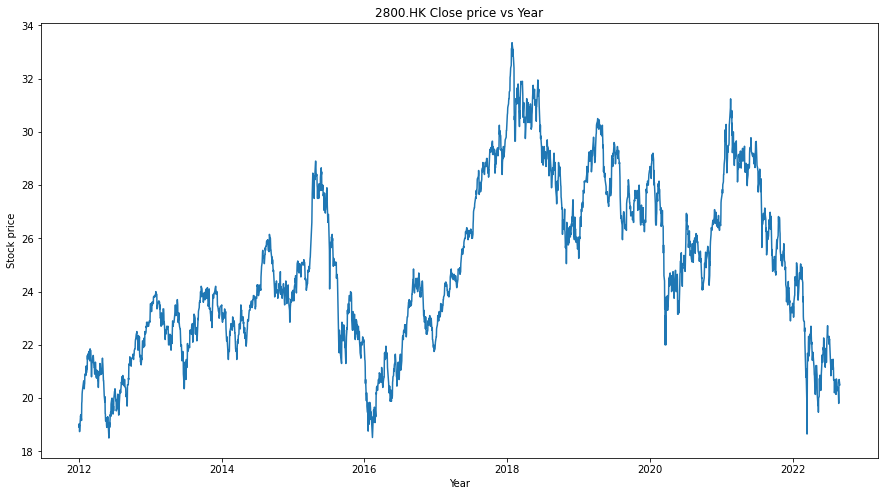

In [ ]:
# plot the close price againt year
plt.figure(figsize=(15,8))
plt.title("2800.HK Close price vs Year")
plt.ylabel("Stock price")
plt.xlabel("Year")
plt.plot(df['Close'])

In [ ]:
# no.of rows and cols in the dataframe
df.shape

(2628, 6)

In [ ]:
# Add technical indicators
df['RSI']=ta.rsi(df.Close, length=15)
#df['EMAF']=ta.ema(df.Close, length=20)
#df['EMAM']=ta.ema(df.Close, length=100)
#df['EMAS']=ta.ema(df.Close, length=150)

# compute the change between open and close
df['Next Change'] = df['Close'] - df.Open
# set the next day change 
df['Next Change'] = df['Next Change'].shift(-1)
# label the next day price trend: uptrend:1 downtrend:0
df['Trend'] = [1 if df['Next Change'][i] > 0 else 0 for i in range(len(df))]
# set the next day closing price
df['Next Close'] = df['Close'].shift(-1)

# drop rows with empty values
df.dropna(inplace=True)
df.reset_index(inplace = True)
df.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

# set the dataset
data_set = df.iloc[:, 1:13]
pd.set_option('display.max_columns', None)
data_set.head()
#print(data_set.shape)
#print(data.shape)
#print(type(data_set))

,Open,High,Low,Close,RSI,Next Change,Trend,Next Close
0,20.500000,20.799999,20.500000,20.650000,82.467690,-0.250000,0,20.350000
1,20.600000,20.700001,20.350000,20.350000,70.720539,0.150000,1,20.500000
2,20.350000,20.700001,20.350000,20.500000,72.796445,0.000000,0,20.549999
3,20.549999,20.750000,20.450001,20.549999,73.468255,0.049999,1,20.900000
4,20.850000,20.950001,20.750000,20.900000,77.614511,0.000000,0,20.900000


In [ ]:
# no.of rows and cols in the dataframe
df.shape

(2612, 9)

In [ ]:
# scale the input features in [0,1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
norm_data_set = scaler.fit_transform(data_set)
print(norm_data_set)

[[0.13333333 0.14521445 0.14353422 ... 0.3832602  0.         0.12457916]
 [0.14000003 0.13861389 0.13337853 ... 0.55947145 1.         0.13468015]
 [0.12333336 0.13861389 0.13337853 ... 0.49339234 0.         0.1380471 ]
 ...
 [0.09733327 0.12673268 0.10697357 ... 0.49339234 0.         0.14814821]
 [0.14666672 0.14125409 0.15030473 ... 0.51101389 1.         0.13602698]
 [0.13199997 0.13333337 0.13811785 ... 0.48458157 0.         0.13468015]]


In [ ]:
# prepare  dataset for the model
#norm_data_set = data_set.to_numpy()
# no. of days of historical data to be considered
backcandles = 10

featureNum = 5
X = []

# extract multiple features from data provided to the model
for j in range(featureNum):
    X.append([])
    # get every past 10 days feature for each prediction
    for i in range(backcandles, norm_data_set.shape[0]):
        X[j].append(norm_data_set[i-backcandles:i, j])

# move feature 'open' from first to third position
X=np.moveaxis(X, [0], [2])

# Choose -1 for last column (i.e. next close), classification else -2...
# ground truth of the model
X, y = np.array(X), np.array(norm_data_set[backcandles:,-1])

# prepare the ground truth of data set by reshaping the 'next close' column
Y=np.reshape(y, (len(y),1))

#print(X)
print(X.shape)
#print(y)
print(Y.shape)

(2602, 10, 5)
(2602, 1)


In [ ]:
# split data 74.78% as training data, 25.22% as testing data
# training data on or before 31/12/2019
# testing data from 1/1/2020 to 31/8/2022
split = int(len(X)*0.7475)
#print(splitlimit)
X_train, X_test = X[:split], X[split:]
Y_train, Y_test = Y[:split], Y[split:]
#print(X_train.shape)
print(X_test.shape)
#print(Y_train.shape)
print(Y_test.shape)
#print(Y_train)
print(Y_test)

(658, 10, 5)
(658, 1)
[[0.67676769]
 [0.68686881]
 [0.68350173]
 [0.67003379]
 [0.67003379]
 [0.65656572]
 [0.69360271]
 [0.69360271]
 [0.71717177]
 [0.71043773]
 [0.70370383]
 [0.70707078]
 [0.72053885]
 [0.70370383]
 [0.64983169]
 [0.67676769]
 [0.63973071]
 [0.64646474]
 [0.5925926 ]
 [0.54882158]
 [0.53872059]
 [0.53872059]
 [0.56228965]
 [0.56902368]
 [0.61952873]
 [0.60942762]
 [0.59932664]
 [0.62289569]
 [0.64309766]
 [0.63636375]
 [0.63973071]
 [0.64983169]
 [0.61952873]
 [0.62962972]
 [0.62289569]
 [0.60606067]
 [0.57575758]
 [0.57912466]
 [0.56902368]
 [0.58249162]
 [0.53535364]
 [0.54882158]
 [0.54545463]
 [0.54208755]
 [0.57575758]
 [0.53872059]
 [0.53535364]
 [0.46801357]
 [0.48821554]
 [0.47474747]
 [0.41077448]
 [0.39730641]
 [0.32659939]
 [0.3434344 ]
 [0.23569026]
 [0.30976437]
 [0.23569026]
 [0.30639729]
 [0.35690234]
 [0.3434344 ]
 [0.35353539]
 [0.32996634]
 [0.36026942]
 [0.32323231]
 [0.33670037]
 [0.33333342]
 [0.36700346]
 [0.40404045]
 [0.38383847]
 [0.40404045

In [ ]:
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

np.random.seed(10)

# create LSTM unit and output layer
lstm_input = Input(shape=(backcandles, featureNum), name='lstm_input')
inputs = LSTM(128, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

# create LSTM model
model = Model(inputs=lstm_input, outputs=output)

# set gradient optimizer
adam = optimizers.Adam()

# compile the model 
model.compile(optimizer=adam, loss='mse')

print(model.summary())

# train the model
history = model.fit(x=X_train, 
          y=Y_train, 
          batch_size=15, 
          epochs=100, 
          shuffle=True, 
          validation_split = 0.1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 10, 5)]           0         
                                                                 
 first_layer (LSTM)          (None, 128)               68608     
                                                                 
 dense_layer (Dense)         (None, 1)                 129       
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 68,737
Trainable params: 68,737
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
117/117 [==============================] - 5s 18ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 2/100
117/117 [==============================] - 2s 14ms/step - loss: 9.8615

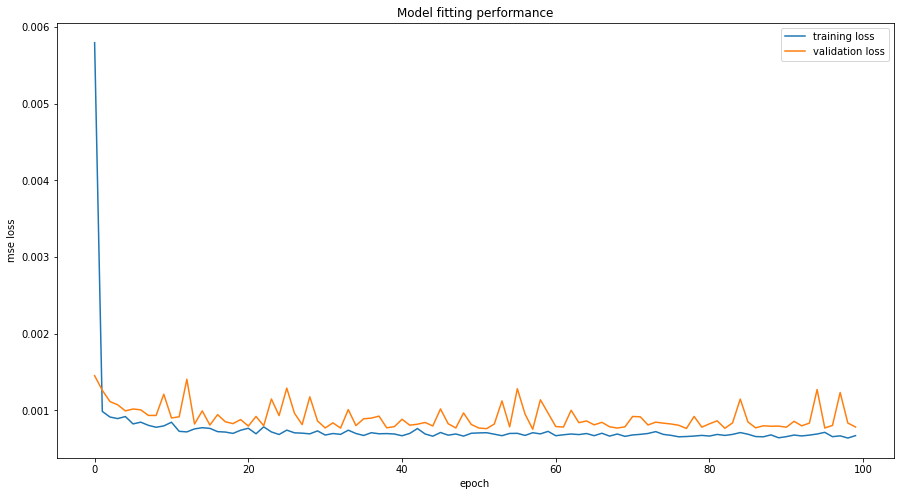

In [ ]:
# plot training and validation loss
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model fitting performance')
plt.ylabel('mse loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

In [ ]:
# Model performance evaluation
from sklearn.metrics import  mean_absolute_error, mean_squared_error, r2_score

Y_pred = model.predict(X_test)

# create zero-fille table with 11 fields (502, 11)
testPredict_dataset_like = np.zeros(shape=(len(Y_pred), featureNum+3) )
testReal_dataset_like = np.zeros(shape=(len(Y_test), featureNum+3) )

# flatten the predicted and actual values and put in the last column
testPredict_dataset_like[:,-1] = Y_pred[:,0]
testReal_dataset_like[:,-1] = Y_test[:,0]

# denormalized the predicted and actual values
testPredict = scaler.inverse_transform(testPredict_dataset_like)
testReal = scaler.inverse_transform(testReal_dataset_like)

# extract predicted values and actual values from denomr. data
y_test = testReal[:, -1]
y_Pred = testPredict [:, -1]

# save predicted values as csv
from numpy import savetxt
savetxt('predict.csv', y_Pred, delimiter=',')
savetxt('nextClose.csv', y_test, delimiter=',')

print(y_Pred.shape)
print(y_Pred)


# evaluate MAE
acc4 = mean_absolute_error(y_test, y_Pred) 
# evaluate MSE
acc2 = mean_squared_error(y_test, y_Pred) 
# evaluate RMSE
acc3 = np.sqrt(mean_squared_error(y_test, y_Pred))
# evaluate R^2
acc = r2_score(y_test, y_Pred) 

print(f"Testing MAE: {acc4}")
print(f"Testing MSE: {acc2}")
print(f"Testing RMSE: {acc3}")
print(f"R2 score: {acc}")



21/21 [==============================] - 1s 13ms/step
(658,)
[28.44695094 28.63082407 28.66891028 28.73271126 28.84083064 28.45777075
 28.53201094 28.20324221 28.78180936 28.88802305 29.19960258 29.21424262
 29.03634676 29.08075102 29.25104716 29.06765022 28.18425531 28.39421142
 27.98535446 28.10082306 27.34511772 26.81598236 26.72561602 26.65116251
 27.00075302 27.10073895 27.73027801 27.58812278 27.36208741 27.74297873
 28.01069924 27.96218709 28.01384853 28.13448009 27.74106508 27.84210697
 27.77611176 27.54154552 27.10589482 27.08128204 26.91201531 27.08831882
 26.43957688 26.63119224 26.71394471 26.55816733 27.02472054 26.52551227
 26.46956062 25.45438152 25.81256264 25.61475404 24.69638281 24.49579535
 23.51555759 23.75180203 22.2529478  23.11262259 22.21121685 22.99030441
 23.66254918 23.55236037 23.74112827 23.38356408 23.73502265 23.37983193
 23.32899721 23.38853496 23.82762572 24.32653746 24.17065786 24.39469017
 24.60458167 24.39243    24.21489173 24.62526138 24.60813812 24

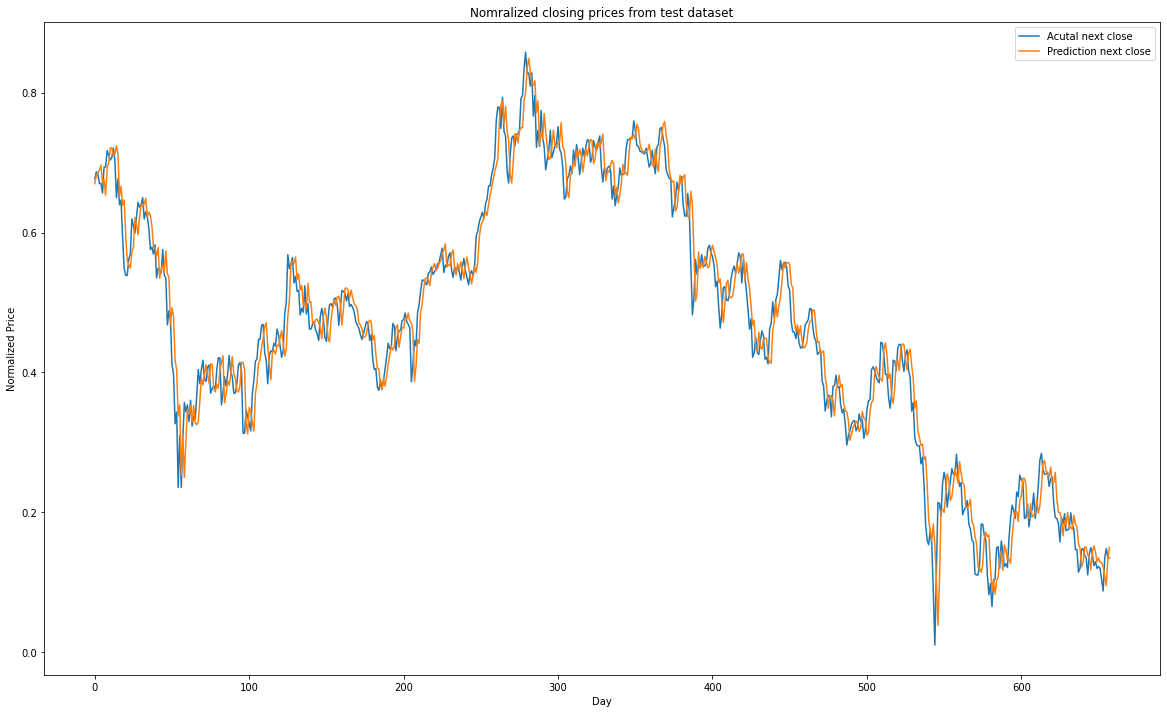

In [ ]:
# plot normalized price against day in testing dataset
# from day 0 to day 657 (1/1/2020 to 31/08/2021)
plt.figure(figsize=(20,12))
plt.title("Nomralized closing prices from test dataset")
plt.plot(Y_test, label = 'Acutal next close')
plt.plot(Y_pred, label = 'Prediction next close')
plt.ylabel('Normalized Price')
plt.xlabel('Day')
plt.legend()
plt.show()

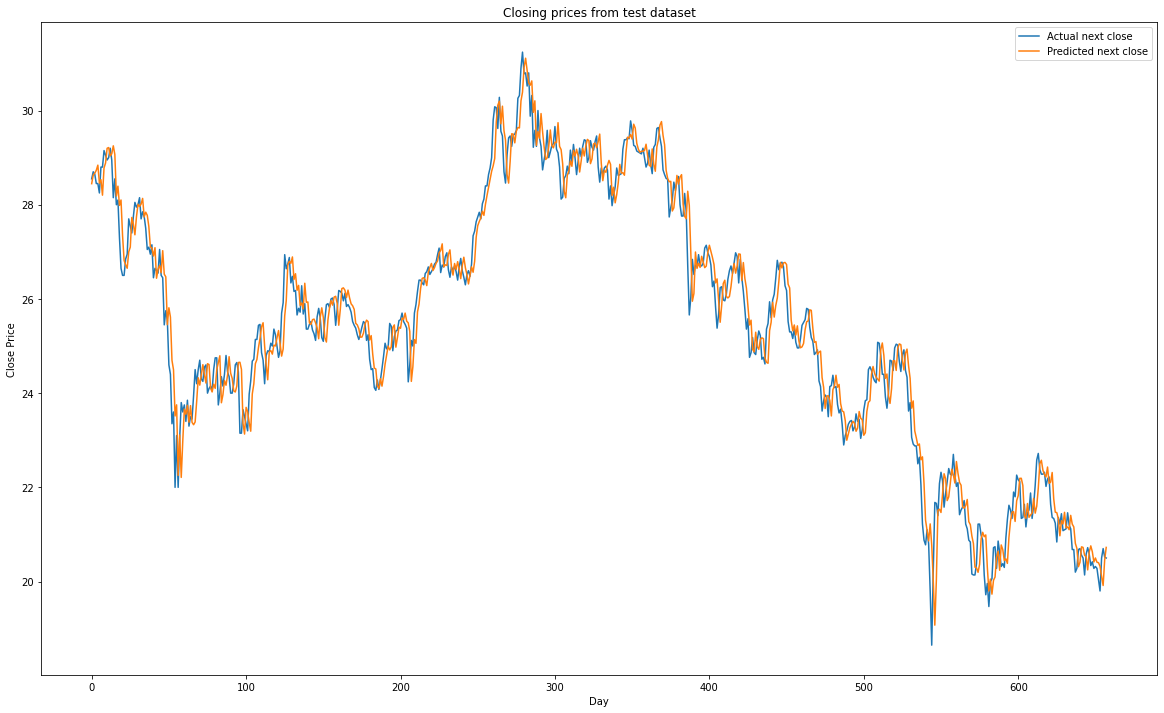

In [ ]:
# plot adjusted price against day in testing dataset
# from day 0 to day 657 (1/1/2020 to 31/08/2021)
plt.figure(figsize=(20,12))
plt.title("Closing prices from test dataset")
plt.plot(testReal[:,-1], label='Actual next close')
plt.plot(testPredict[:,-1], label='Predicted next close')
plt.ylabel('Close Price')
plt.xlabel('Day')
plt.legend()
plt.show()